In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_fixed.csv', index=False)

 # entry point
run()

Using TensorFlow backend.


1) Test RMSE: 112.317
2) Test RMSE: 108.166
3) Test RMSE: 96.133
4) Test RMSE: 103.697
5) Test RMSE: 126.152
6) Test RMSE: 93.672
7) Test RMSE: 219.851
8) Test RMSE: 136.269
9) Test RMSE: 215.414
10) Test RMSE: 91.074
          results
count   10.000000
mean   130.274624
std     48.172412
min     91.074469
25%     98.024194
50%    110.241527
75%    133.739846
max    219.850996


In [2]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	for i in range(updates):
		model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# run a repeated experiment
def experiment(repeats, series, updates):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		train_copy = numpy.copy(train_scaled)
		predictions = list()
		for i in range(len(test_scaled)):
			# update model
			if i > 0:
				update_model(lstm_model, train_copy, 1, updates)
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
			# add to training set
			train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	updates = 2
	results['results'] = experiment(repeats, series, updates)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_update_2.csv', index=False)

 # entry point
run()

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1) Test RMSE: 101.343
2) Test RMSE: 102.898
3) Test RMSE: 106.253
4) Test RMSE: 105.410
5) Test RMSE: 129.737
6) Test RMSE: 103.495
7) Test RMSE: 93.075
8) Test RMSE: 161.817
9) Test RMSE: 102.015
10) Test RMSE: 97.715
          results
count   10.000000
mean   110.375893
std     20.485925
min     93.075420
25%    101.511002
50%    103.196456
75%    106.042132
max    161.817147


In [3]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	for i in range(updates):
		model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# run a repeated experiment
def experiment(repeats, series, updates):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		train_copy = numpy.copy(train_scaled)
		predictions = list()
		for i in range(len(test_scaled)):
			# update model
			if i > 0:
				update_model(lstm_model, train_copy, 1, updates)
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
			# add to training set
			train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	updates = 5
	results['results'] = experiment(repeats, series, updates)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_update_5.csv', index=False)

 # entry point
run()

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1) Test RMSE: 127.924
2) Test RMSE: 102.630
3) Test RMSE: 103.979
4) Test RMSE: 99.711
5) Test RMSE: 100.047
6) Test RMSE: 100.267
7) Test RMSE: 100.727
8) Test RMSE: 112.243
9) Test RMSE: 94.147
10) Test RMSE: 152.942
          results
count   10.000000
mean   109.461802
std     17.935034
min     94.146711
25%    100.102391
50%    101.678453
75%    110.177049
max    152.942406


In [4]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	for i in range(updates):
		model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# run a repeated experiment
def experiment(repeats, series, updates):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		train_copy = numpy.copy(train_scaled)
		predictions = list()
		for i in range(len(test_scaled)):
			# update model
			if i > 0:
				update_model(lstm_model, train_copy, 1, updates)
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
			# add to training set
			train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	updates = 10
	results['results'] = experiment(repeats, series, updates)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_update_10.csv', index=False)

 # entry point
run()

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1) Test RMSE: 98.683
2) Test RMSE: 97.160
3) Test RMSE: 101.970
4) Test RMSE: 107.746
5) Test RMSE: 101.754
6) Test RMSE: 112.673
7) Test RMSE: 101.420
8) Test RMSE: 173.106
9) Test RMSE: 139.106
10) Test RMSE: 95.201
          results
count   10.000000
mean   112.882052
std     24.668364
min     95.201331
25%     99.367072
50%    101.861958
75%    111.441426
max    173.106305


In [5]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	for i in range(updates):
		model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# run a repeated experiment
def experiment(repeats, series, updates):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		train_copy = numpy.copy(train_scaled)
		predictions = list()
		for i in range(len(test_scaled)):
			# update model
			if i > 0:
				update_model(lstm_model, train_copy, 1, updates)
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
			# add to training set
			train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	updates = 20
	results['results'] = experiment(repeats, series, updates)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_update_20.csv', index=False)

 # entry point
run()

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1) Test RMSE: 108.027
2) Test RMSE: 97.862
3) Test RMSE: 98.780
4) Test RMSE: 99.636
5) Test RMSE: 110.634
6) Test RMSE: 100.596
7) Test RMSE: 121.586
8) Test RMSE: 100.350
9) Test RMSE: 93.320
10) Test RMSE: 148.394
          results
count   10.000000
mean   107.918458
std     16.362910
min     93.319578
25%     98.994411
50%    100.472821
75%    109.981830
max    148.393712


In [6]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	for i in range(updates):
		model.fit(X, y, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# run a repeated experiment
def experiment(repeats, series, updates):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		train_copy = numpy.copy(train_scaled)
		predictions = list()
		for i in range(len(test_scaled)):
			# update model
			if i > 0:
				update_model(lstm_model, train_copy, 1, updates)
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
			# add to training set
			train_copy = concatenate((train_copy, test_scaled[i,:].reshape(1, -1)))
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	updates = 50
	results['results'] = experiment(repeats, series, updates)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_update_50.csv', index=False)

 # entry point
run()

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


1) Test RMSE: 93.074
2) Test RMSE: 92.688
3) Test RMSE: 103.647
4) Test RMSE: 141.505
5) Test RMSE: 103.364
6) Test RMSE: 106.270
7) Test RMSE: 152.135
8) Test RMSE: 117.551
9) Test RMSE: 97.724
10) Test RMSE: 105.865
          results
count   10.000000
mean   111.382365
std     20.160852
min     92.688079
25%     99.134214
50%    104.755948
75%    114.730659
max    152.135267


            fixed    update_2    update_5   update_10   update_20   update_50
count   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000
mean   130.274624  110.375800  109.461700  112.881900  107.918500  111.382365
std     48.172412   20.485986   17.934916   24.668339   16.362949   20.160852
min     91.074469   93.075000   94.147000   95.201000   93.320000   92.688079
25%     98.024194  101.511000  100.102000   99.367250   98.994000   99.134214
50%    110.241527  103.196500  101.678500  101.862000  100.473000  104.755948
75%    133.739846  106.042250  110.177000  111.441250  109.982250  114.730659
max    219.850996  161.817000  152.942000  173.106000  148.394000  152.135267


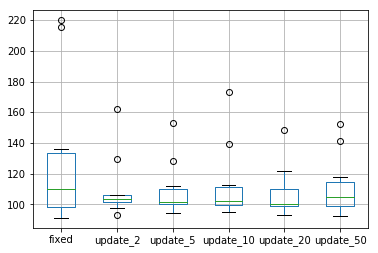

In [8]:
from pandas import DataFrame
from pandas import read_csv
from matplotlib import pyplot
# load results into a dataframe
filenames = ['experiment_fixed.csv',
	'experiment_update_2.csv', 'experiment_update_5.csv',
	'experiment_update_10.csv', 'experiment_update_20.csv',
	'experiment_update_50.csv']
results = DataFrame()
for name in filenames:
	results[name[11:-4]] = read_csv(name, header=0)
# describe all results
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()